Calculating global scale...
Global value range: -18.26 to 20.68
Using scale: -20.68 to 20.68
Using threshold: 4.00

Processing pIPS_right...
Group average saved to: group_average_pIPS_right.nii.gz


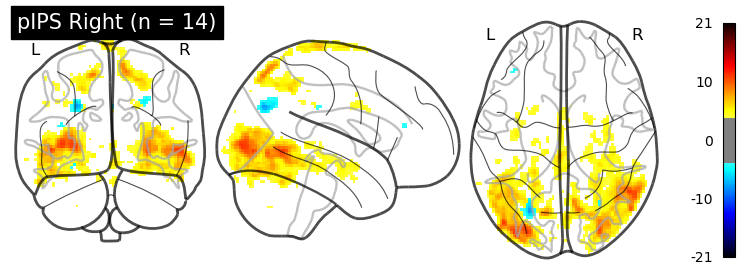


Processing pIPS_left...
Group average saved to: group_average_pIPS_left.nii.gz


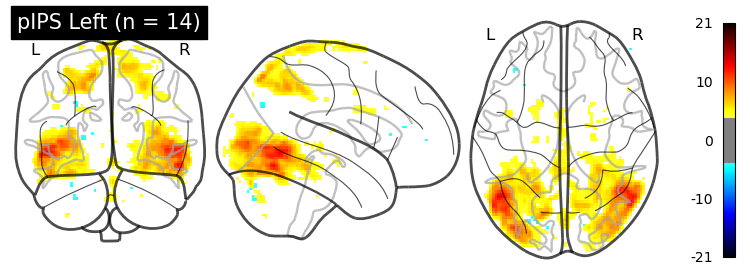


Processing LO_right...
Group average saved to: group_average_LO_right.nii.gz


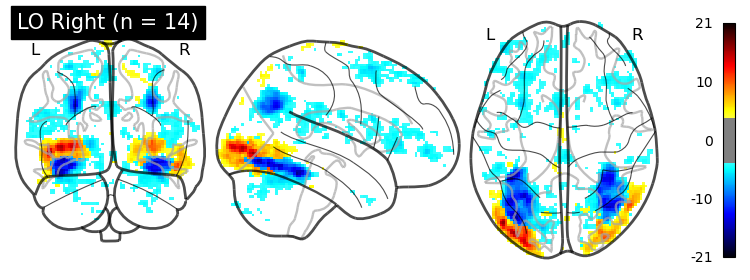


Processing LO_left...
Group average saved to: group_average_LO_left.nii.gz


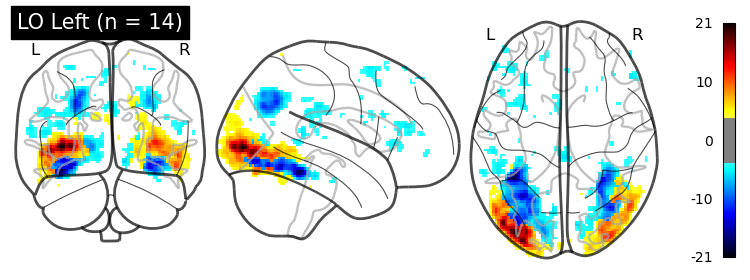


Processing complete.


In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import glob
import os
import re

def load_and_average(file_pattern):
    """Helper function to load and average files"""
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found matching the pattern: {file_pattern}")
        return None, None, []
    
    # Extract and sort subject numbers
    subject_files = {}
    for f in files:
        match = re.search(r'sub-(\d+)', f)
        if match:
            subject_files[match.group(1)] = f
    
    sorted_subjects = sorted(subject_files.keys(), key=int)
    
    # Load all images
    images = [nib.load(subject_files[subject]) for subject in sorted_subjects]
    
    # Check if all images have the same shape
    shapes = [img.shape for img in images]
    if len(set(shapes)) > 1:
        print("Error: Not all images have the same shape.")
        return None, None, []
    
    # Calculate the average
    avg_data = np.mean([img.get_fdata() for img in images], axis=0)
    avg_img = nib.Nifti1Image(avg_data, images[0].affine, images[0].header)
    
    return avg_data, avg_img, sorted_subjects

def find_global_scale(base_path, regions):
    """Find global min and max values across all group averages"""
    all_averages = []
    
    for region in regions:
        file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
        avg_data, _, _ = load_and_average(file_pattern)
        if avg_data is not None:
            all_averages.append(avg_data)
    
    if all_averages:
        global_min = min(np.min(avg) for avg in all_averages)
        global_max = max(np.max(avg) for avg in all_averages)
        return global_min, global_max
    return None, None

def group_average(file_pattern, region, vmin, vmax, threshold):
    # Load and average data
    avg_data, avg_img, sorted_subjects = load_and_average(file_pattern)
    
    if avg_img is None:
        return
    
    # Save the average image
    output_path = f'group_average_{region}.nii.gz'
    nib.save(avg_img, output_path)
    print(f"Group average saved to: {output_path}")

    # Format the title: split the region name and format it nicely
    region_parts = region.split('_')
    if len(region_parts) == 2:
        title = f"{region_parts[0]} {region_parts[1].capitalize()} (n = {len(sorted_subjects)})"

    # Display the average image with consistent scaling
    plotting.plot_glass_brain(avg_img, threshold=threshold, colorbar=True, 
                            plot_abs=False, vmin=vmin, vmax=vmax,
                            title=title)
    plt.show()

# Base path
base_path = '/lab_data/behrmannlab/vlad/ptoc'

# Regions to process
regions = ['pIPS_right', 'pIPS_left', 'LO_right', 'LO_left']

# First find global min and max
print("Calculating global scale...")
global_min, global_max = find_global_scale(base_path, regions)
print(f"Global value range: {global_min:.2f} to {global_max:.2f}")

# Set symmetric limits based on the absolute maximum value
sym_max = max(abs(global_min), abs(global_max))
vmin, vmax = -sym_max, sym_max
##to manually set the scales replace the above line with the following line
#vmin, vmax = -25, 25

# Set threshold as a percentage of the maximum value (e.g., 10%)
#threshold = 0.1 * sym_max 
threshold = 4

print(f"Using scale: {vmin:.2f} to {vmax:.2f}")
print(f"Using threshold: {threshold:.2f}")

# Loop through regions
for region in regions:
    print(f"\nProcessing {region}...")
    file_pattern = f'{base_path}/sub-*/ses-01/derivatives/gca/combined_object_{region}_mni.nii.gz'
    group_average(file_pattern, region, vmin=vmin, vmax=vmax, threshold=threshold)

print("\nProcessing complete.")